In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import RMSprop


In [ ]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name,duration=3
                                  ,offset=0.5)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    #print(mfccs)
    
    return mfccs

In [ ]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"

# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
##### load radvess speech data #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
radvess_speech_labels1 = []
folder_path = '/content/drive/MyDrive/SpeechDrive' 
for subdir, dirs, files in os.walk(folder_path):
      for file in files:
        #y, sr = librosa.load(os.path.join(subdir, file),duration=3,offset=0.5)
        if (find_emotion_T(file) != "-1"): #TESS database validation
            name1 = find_emotion_T(file)
        else:                              #RAVDESS database validation
            name = int(file[7:8]) - 1 
        radvess_speech_labels.append(name)
        # radvess_speech_labels1.append(name)
        wav_file_name = os.path.join(subdir, file)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [ ]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(4240, 8)

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.30, random_state=0)

In [ ]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [ ]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    # model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    # model.add(Dense(32))
    # model.add(Dropout(0.4))
    # model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples],-1)

In [ ]:
w.shape

(3392, 40, 1)

In [ ]:
### train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), batch_size = 32, epochs=50, shuffle=True)

Epoch 1/50
106/106 [==============================] - 9s 47ms/step - loss: 1.2332 - accuracy: 0.6147 - val_loss: 0.0453 - val_accuracy: 1.0000
Epoch 2/50
106/106 [==============================] - 4s 40ms/step - loss: 0.9356 - accuracy: 0.6616 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 3/50
106/106 [==============================] - 4s 40ms/step - loss: 0.8820 - accuracy: 0.6787 - val_loss: 0.1180 - val_accuracy: 0.9906
Epoch 4/50
106/106 [==============================] - 4s 40ms/step - loss: 0.8517 - accuracy: 0.6860 - val_loss: 0.1257 - val_accuracy: 0.9976
Epoch 5/50
106/106 [==============================] - 4s 40ms/step - loss: 0.8220 - accuracy: 0.6966 - val_loss: 0.0379 - val_accuracy: 0.9976
Epoch 6/50
106/106 [==============================] - 4s 41ms/step - loss: 0.8172 - accuracy: 0.6972 - val_loss: 0.3368 - val_accuracy: 0.9222
Epoch 7/50
106/106 [==============================] - 4s 41ms/step - loss: 0.8052 - accuracy: 0.6966 - val_loss: 0.0396 - val_accuracy: 0.9976

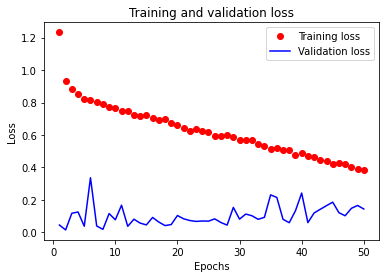

In [ ]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

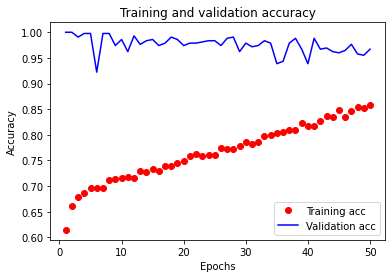

In [ ]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
### evaluate using model A
model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples + validation_samples:])

14/14 [==============================] - 0s 15ms/step - loss: 0.0447 - accuracy: 0.9811


[0.04468023031949997, 0.9811320900917053]

In [ ]:
model_A.save_weights("Model_LSTM.h5")

In [ ]:
#Model Testing

import IPython.display as ipd



for dirname,_, filenames in os.walk('/content/drive/MyDrive/SpeechDrive/Actor_11'):
    for filename in filenames:
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ipd.Audio(wav_file_name)
        a = extract_mfcc(wav_file_name)
        #a.shape
        a1 = np.asarray(a)
        #a1.shape
        q = np.expand_dims(a1,-1)
        qq = np.expand_dims(q,0)
        qq.shape
        pred = model_A.predict(qq)
        preds=pred.argmax(axis=1)
        preds
        d={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
        preds=int(preds)
        print(d[preds])

calm
calm
sad
calm
calm
calm
neutral
calm
sad
angry
disgust
surprised
happy
fearful
surprised
surprised
angry
sad
disgust
disgust
calm
calm
fearful
fearful
happy
disgust
disgust
sad
surprised
surprised
calm
angry
happy
fearful
calm
sad
fearful
calm
disgust
angry
calm
disgust
disgust
neutral
surprised
surprised
neutral
happy
sad
disgust
calm
disgust
disgust
disgust
fearful
calm
sad
surprised
surprised
sad


In [ ]:
path_ = '/content/drive/MyDrive/SpeechDrive/Actor_01/03-01-02-02-01-01-01.wav'

In [ ]:
import IPython.display as ipd
ipd.Audio(path_)

In [ ]:
a = extract_mfcc(path_)
#a.shape
a1 = np.asarray(a)
#a1.shape
q = np.expand_dims(a1,-1)
qq = np.expand_dims(q,0)
qq.shape
pred = model_A.predict(qq)
preds=pred.argmax(axis=1)
preds
d={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
preds=int(preds)

In [ ]:
print(d[preds])

calm


In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model_A.to_json()
#save the model architecture to JSON file
with open('speech_emotion.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
from keras.models import model_from_json
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Text(0.5, 51.0, 'Predicted emotion')

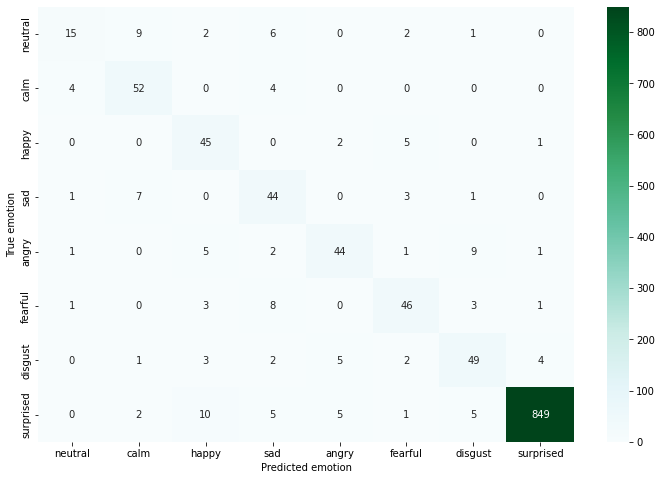

In [ ]:
y_test_class = np.argmax(y_test, axis=1)
predictions = model_A.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
saved_model_path = '/content/speech_emotion.json'
saved_weights_path = '/content/Model_LSTM.h5'

#Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 activation_1 (Activation)   (None, 8)                 0         
                                                                 
Total params: 67,592
Trainable params: 67,592
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'  
}
emo_list = list(emotions.values())

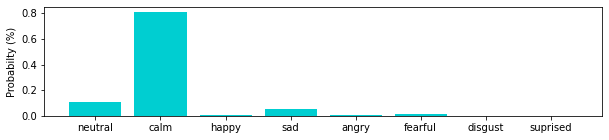

max emotion: calm
----------------------------------------------------------------------------------------------------


In [ ]:
total_predictions=[]
predictions = model_A.predict(qq, use_multiprocessing=True)
pred_list = list(predictions)
pred_np = np.squeeze(np.array(pred_list).tolist(), axis=0) # Get rid of 'array' & 'dtype' statments.
total_predictions.append(pred_np)

# Present emotion distribution for a sequence (7.1 secs).
fig = plt.figure(figsize = (10, 2))
plt.bar(emo_list, pred_np, color = 'darkturquoise')
plt.ylabel("Probabilty (%)")
plt.show()

max_emo = np.argmax(predictions)
print('max emotion:', emotions.get(max_emo,-1))

print(100*'-')